In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import scipy as sp
import seaborn as sn
import pandas as pd
from scipy.stats import gaussian_kde
from sympy import *
import math
import matplotlib.pylab as pl
%matplotlib inline

import os 
import hedfpy

from hedfpy.EDFOperator import EDFOperator
from hedfpy.HDFEyeOperator import HDFEyeOperator
from hedfpy.EyeSignalOperator import EyeSignalOperator, detect_saccade_from_data

sn.set(style="ticks")
import warnings
warnings.filterwarnings("ignore")

from PIL import Image

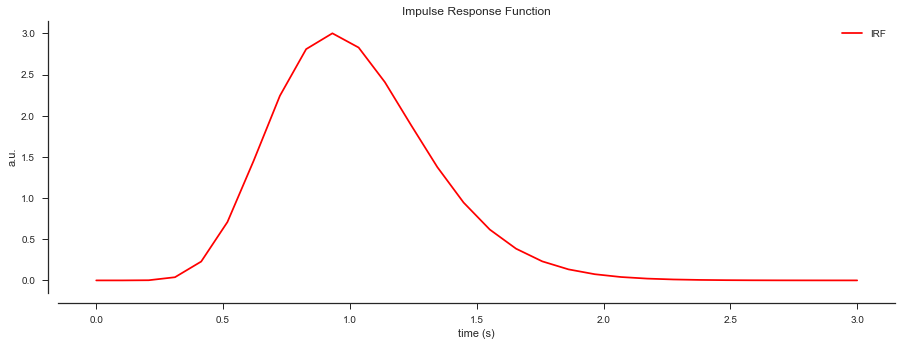

In [4]:
# define an Impulse Response Function:
def pupil_IRF(timepoints, s=1.0/(10**26), n=10.1, tmax=0.93):
    
    """ pupil_IRF defines the IRF (response to a transient input) of the pupil.
    
    Parameters
    ----------
    t: IRF is defined with respect to 't'
    s: scaling factor
    n: sets the width
    tmax: sets the time to peak 
    IRF_len: function is evaluated for t = [0:IRF_len]
    
    Returns
    -------
    y: IRF evaluated for t = [0:IRF_len]
    yprime: IRF first derivative evaluated for t = [0:IRF_len]
    
    """
    
    # in sympy:
    t = Symbol('t')
    y = ( (s) * (t**n) * (math.e**((-n*t)/tmax)) )
    yprime = y.diff(t)
    
    # lambdify:
    y = lambdify(t, y, "numpy")
    yprime = lambdify(t, yprime, "numpy")
    
    # evaluate:
    y = y(timepoints)
    yprime = yprime(timepoints)
    
    return (y, yprime)

# create the IRF:
sample_rate = 10
IRF_len = 3.0 # in seconds
timepoints = np.linspace(0,IRF_len,IRF_len*sample_rate)

IRF, IRF_prime = pupil_IRF(timepoints=timepoints)
IRF = IRF / IRF.std()
IRF_prime = IRF_prime / IRF_prime.std()

# plot the IRF:
fig = pl.figure(figsize = (15,5))
pl.plot(timepoints, IRF, color='r')
# pl.plot(timepoints, IRF_prime, color='g')
pl.legend(['IRF'])
pl.title('Impulse Response Function')
pl.xlabel('time (s)')
pl.ylabel('a.u.')
sn.despine(fig=fig, offset=10)

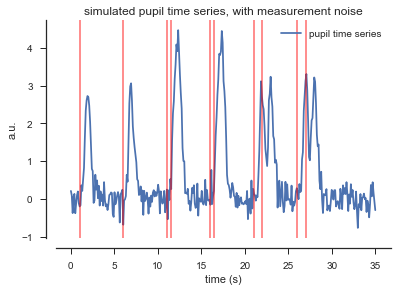

In [14]:
# input:
duration = 35 # in seconds
times = np.array([1,6,11,11.5,16,16.5,21,22,26,27])
input_signal = np.zeros(duration * sample_rate)
for i in times:
    input_signal[int(i*sample_rate)] = 1

# convolve inputs with IRF:    
convolved_signal = (sp.convolve(input_signal, IRF, 'full'))[:-(IRF.shape[0]-1)]

# let's add some noise:
convolved_signal_noise = convolved_signal + np.random.normal(0,0.25,len(convolved_signal))

timepoints = np.linspace(0,duration,duration*sample_rate)
# plot simulated convolved signal with noise:
fig = pl.figure()
pl.plot(timepoints, convolved_signal_noise)
for i in times:
    pl.axvline(i, color='r', alpha=0.5)
pl.legend(['pupil time series'], loc=1)
pl.title('simulated pupil time series, with measurement noise')
pl.xlabel('time (s)')
pl.ylabel('a.u.')
sn.despine(fig=fig, offset=10)

Let's epoch the data and compute mean response.

In [20]:
times*sample_rate

array([  10.,   60.,  110.,  115.,  160.,  165.,  210.,  220.,  260.,  270.])

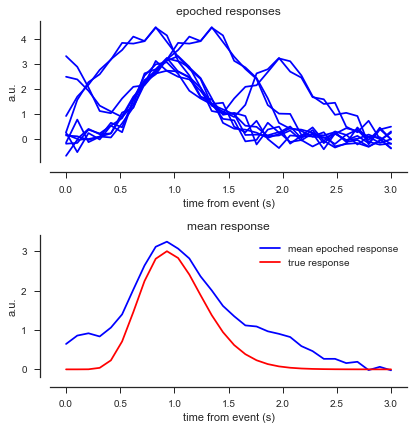

In [22]:
# times for epoching:
epoch_times = [0, 3] # in seconds

# mean response:
epochs = np.vstack([convolved_signal_noise[int(i)+int(epoch_times[0]*sample_rate):int(i)+int(epoch_times[1]*sample_rate)] for i in times*sample_rate])
mean_response = np.mean(epochs, axis=0)

# plot mean response versus IRF:
timepoints = np.linspace(0,3,3*sample_rate)
fig = pl.figure(figsize=(6,6))
timepoints = np.linspace(epoch_times[0],epoch_times[1],(epoch_times[1]-epoch_times[0])*sample_rate)
fig.add_subplot(211)
for data in epochs:
    pl.plot(timepoints,data, color='b')
pl.title('epoched responses')
pl.xlabel('time from event (s)')
pl.ylabel('a.u.')
sn.despine(fig=fig, offset=10)
fig.add_subplot(212)
pl.plot(timepoints, mean_response, color='b')
pl.plot(timepoints, IRF, color='r')
pl.legend(['mean epoched response', 'true response'])
pl.title('mean response')
pl.xlabel('time from event (s)')
pl.ylabel('a.u.')
fig.tight_layout()
sn.despine(fig=fig, offset=10)

This is obviously not good... what we need to do is to is correct for for overlap between temporally adjacent responses...
We'll have to try deconvolution.
First make a design matrix:

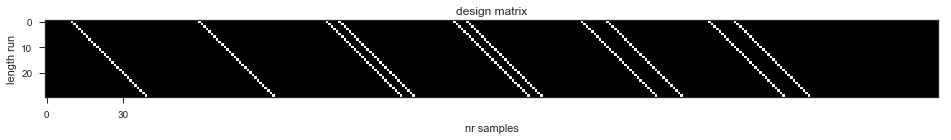

In [27]:

# make design matrix:
nr_samples = 3 * sample_rate # here we define the length of the deconvolution response we're interested in (30 samples = 3-s in our case).
designMatrix = np.zeros((nr_samples, duration*sample_rate))
for i in (times*sample_rate):
    for j in range(int(nr_samples)):
        designMatrix[j,int(i+j)] = 1

# plot design matrix:
fig = pl.figure(figsize=(16,4))
pl.imshow(designMatrix, cmap='gray')
pl.xticks([0,nr_samples])
pl.title('design matrix')
pl.xlabel('nr samples')
pl.ylabel('length run')

Now let's do deconvolution.

For every regressor (in the above example, we have 30 regressors (the duration in samples of the response we are interested in) we want to find an associated scalar value (the "beta", $b$) that we can use to scale that particular regressor with, such that it best describes the measured data. In a deconvolution analysis, with a procedure called "multiple regression" we look for betas that minimimize the sum of squares of errors across all $k$ regressors in our design matrix at the same time.

To do so, we set up the following equation:

$$ b = (X'X)^{-1} X'y $$

In which, 

- $b$ is a vector containing the betas (size: number of regressors; in the above example: 30). In the case of deconvolution, this vector is the actual deconvolved response to some input;
- $X$ is the design matrix (size: length measured time series x number of regressors);
- $y$ is the measured BOLD timeseries.

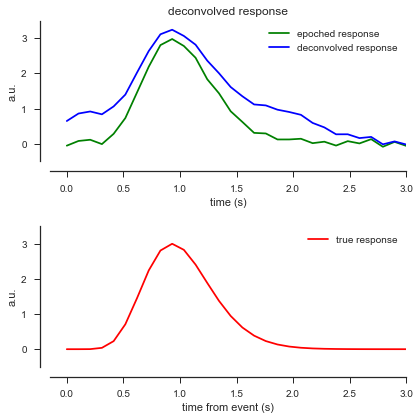

In [32]:
# deconvolution:
designMatrix = np.mat(designMatrix).T
deconvolved_response = ((designMatrix.T * designMatrix).I * designMatrix.T) * np.mat(convolved_signal_noise).T
deconvolved_response = np.array(deconvolved_response)

# plot deconvoled response versus true response:
timepoints = np.linspace(0,3,3*sample_rate)
fig = pl.figure(figsize=(6,6))
fig.add_subplot(211)
pl.plot(timepoints,deconvolved_response, color='g')
pl.plot(timepoints,mean_response, color='b')
pl.xlim(xmax=3)
pl.ylim(ymin=-0.5, ymax=3.5)
pl.legend(['epoched response','deconvolved response'])
pl.title('deconvolved response')
pl.xlabel('time (s)')
pl.ylabel('a.u.')
sn.despine(fig=fig, offset=10)
fig.add_subplot(212)
pl.plot(timepoints,IRF, color='r')
pl.xlim(xmax=3)
pl.ylim(ymin=-0.5, ymax=3.5)
pl.legend(['true response'])
pl.xlabel('time from event (s)')
pl.ylabel('a.u.')
sn.despine(fig=fig, offset=10)
pl.tight_layout()